In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import scipy.io as scipy_io
from sklearn.model_selection import train_test_split
from scipy import sparse
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline


### load data

In [5]:
data = pd.read_csv('train.csv')
members = pd.read_csv('members.csv')
songs = pd.read_csv('songs.csv')
song_extra_info = pd.read_csv('song_extra_info.csv')

### split data into train & validation

In [21]:
feature_data = data.drop('target',1)
target_data = data['target']
X_train, X_val, Y_train, Y_val = train_test_split(feature_data, target_data, train_size=0.75)

train = X_train.join(Y_train)  # train set
test = X_val.join(Y_val)  # validation set

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### original matrix

In [22]:
rowin = train['msno'].unique()
colin = train['song_id'].unique()
spm = sparse.lil_matrix((len(rowin),len(colin)))
dictuser = dict(zip(rowin,range(len(rowin))))
dictsong = dict(zip(colin,range(len(colin))))
for ind in train.index:
    userp = dictuser[train.msno[ind]]
    songp = dictsong[train.song_id[ind]]
    spm[userp,songp] = (2 if train.target[ind] == 1 else 1)
split_orig_mat = sparse.lil_matrix(spm)

### test matrix

In [ ]:
# encode extra test userid and songid with same dictionary as train
train_userid = set(train.msno.unique())
test_userid = set(test.msno.unique())
diff_userid = test_userid - train_userid   # id that in test but not in train
testuserdict = dict(zip(diff_userid,range(len(train_userid)+len(diff_userid))))

train_songid = set(train.song_id.unique())
test_songid = set(test.song_id.unique())
diff_songid = test_songid - train_songid   # id that in test but not in train
testsongdict = dict(zip(diff_songid,range(len(train_songid)+len(diff_songid))))

In [ ]:
# join two dictionaries
dictuser.update(testuserdict)
dictsong.update(testsongdict)

In [ ]:
# convert ids from str to number
testmat = pd.DataFrame()
testmat['userid'] = test.msno.apply(lambda x: dictuser[x])
testmat['songid'] = test.song_id.apply(lambda x: dictsong[x])


### model

In [ ]:
# %load source.py
import pdb
import time
from sklearn.neighbors import BallTree
from sklearn.decomposition import TruncatedSVD

""" truncated SVD and ball_tree"""
matrix = split_orig_mat
svd =  TruncatedSVD(n_components=10)
matrix_down = svd.fit_transform(matrix)
tree= BallTree(matrix_down,leaf_size=5)

query_matrix = testmat
user_id = query_matrix[:,0]
song_id = query_matrix[:,1]
output=np.zeros(user_id.size)
t_past = time.time()

""" without optimization """
for item in range(user_id.size):
    if item %1000==0:
        print str(item)+': time: '+ str(time.time()-t_past)
        t_past = time.time()
    if user_id[item]>=matrix.shape[0] or song_id[item]>=matrix.shape[1] :
        output[item] =0.5
    else:
        distance, ids =  tree.query(matrix_down[user_id[item],:].reshape(1,-1), k=5000)
        similarity = (distance-distance.min())/(distance.max()-distance.min())
        similarity = (1 - similarity)
        similarity = similarity.T

        song_val = matrix[ids,song_id[item]].todense()
        useful_id = (song_val!=0)

        output[item]=np.multiply((song_val[useful_id]).squeeze(),similarity[useful_id]).sum()/(np.sum(similarity[useful_id])+0.001)/2.0

scipy_io.savemat('./mat/result_val.mat',{'output':output})

### plot AUC

In [10]:
val_preds = scipy_io.loadmat('./mat/result_val.mat')['output']
val_preds = val_preds.T

val_true = test['target']

In [60]:
fpr, tpr, thresholds = metrics.roc_curve(val_true, val_preds)
auc_score = metrics.auc(fpr,tpr)

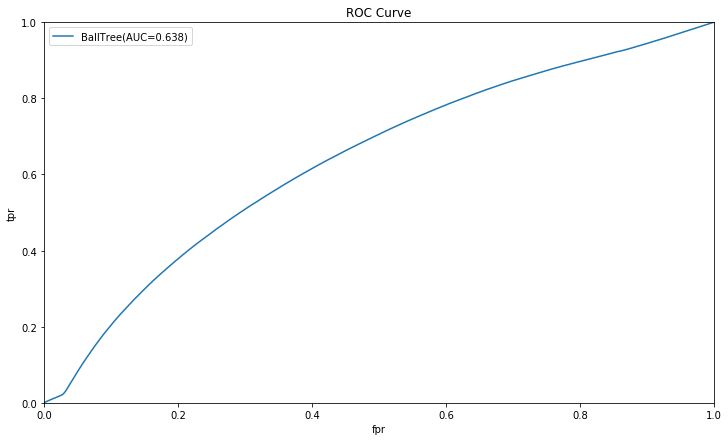

In [64]:
plt.figure(figsize=(12,7))
plt.plot(fpr, tpr, label='BallTree(AUC=%.3f)' % auc_score)

plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC Curve")
plt.legend()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()